In [20]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu121
12.1


In [21]:
device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
device_name = torch.cuda.get_device_name(0)

print("CUDA disponible :", torch.cuda.is_available())
print("Nombre de GPU :", torch.cuda.device_count())
print("Nom GPU :", torch.cuda.get_device_name(0))
print("Device actuel :", torch.cuda.current_device())

CUDA disponible : True
Nombre de GPU : 1
Nom GPU : NVIDIA GeForce GTX 1650
Device actuel : 0


# I - Import librairies & data

In [22]:
import pandas as pd
import io
import os
import re
import shutil
import tarfile
import string
import torch
import tiktoken
import requests
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import transformers


In [23]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [24]:
colonnes_a_fusionner = ['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
data['v2'] = data[colonnes_a_fusionner].apply(
    # 1. Convertit la ligne en chaîne de caractères (pour gérer les NaN)
    # 2. Filtre les valeurs non-NaN (la condition 'pd.notna(x)' est le filtre)
    # 3. Joindre les valeurs restantes avec le séparateur désiré (' / ')
    lambda x: ' / '.join(x.dropna().astype(str)),
    axis=1
)
data = data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
data

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [25]:
data.rename(
    columns={
        "v1" : "labels",
        "v2" : "text"
    },
    inplace=True)
data

,labels,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# II - stats & preprocessing

In [26]:
data.describe(include='all')

,labels,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Labelization

In [27]:
# encoder v1 :
encod = {"ham" : 0,
         "spam" : 1}

data['labels'] = data['labels'].map(encod)
data.head()

,labels,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# III - Simple deep learning model

## 1. Tokenization

In [28]:
tokenizer = tiktoken.get_encoding("cl100k_base")

def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

train_tokens = encode_texts(data["text"])

# print the first ten tokens of the first tokenized sentence
train_tokens[0][:10]


[11087, 3156, 16422, 647, 1486, 11, 14599, 497, 16528, 1193]

In [29]:
tokenizer.n_vocab


100277

## 2. Define pad sequence

In [30]:
# How are sequence lengths distributed?
seq_lens = [len(seq) for seq in train_tokens]
print("avg seq len :",np.mean(seq_lens))
print("max seq len :",np.max(seq_lens))


avg seq len : 22.704953338119168
max seq len : 259


In [31]:
def pad_sequences(sequences, max_length=100):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

train_tokens = pad_sequences(train_tokens, max_length=np.max(seq_lens))

## 3. Split data & create dataloaders

In [32]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

df_dataset = IMDBDataset(train_tokens, data['labels'])

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(df_dataset))
val_size = len(df_dataset) - train_size
train_dataset, val_dataset = random_split(df_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [33]:
text, label = next(iter(train_loader))
print(label)
print(text)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[81556,  1047,   961,  ...,     0,     0,     0],
        [ 9642,   602,  3463,  ...,     0,     0,     0],
        [   40,  1935,   433,  ...,     0,     0,     0],
        ...,
        [10445,  1364,  6944,  ...,     0,     0,     0],
        [   40, 40464,  5916,  ...,     0,     0,     0],
        [ 5159,  2324, 60807,  ...,     0,     0,     0]])


## 4. Text classification model

In [34]:
# Get the vocabulary size from the tokenizer
# This represents the total number of unique words in the dataset,
# which will be used as the input size for the embedding layer.
vocab_size = tokenizer.n_vocab

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        return torch.sigmoid(self.fc(pooled))                                   # Sigmoid pour avoir une valeur 0 ou 1

model = TextClassifier(vocab_size=tokenizer.n_vocab,
                      embed_dim=16,                                             # The size of each word's embedding vector. (= le nombre de sens différents d'un mot)
                      num_class=1)


In [35]:
from torchinfo import summary

print(model)

# Print model summary
summary(model, input_data=text)  # (batch_size, input_features)

TextClassifier(
  (embedding): Embedding(100277, 16, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 259, 16]             1,604,432
├─AdaptiveAvgPool1d: 1-2                 [32, 16, 1]               --
├─Linear: 1-3                            [32, 1]                   17
Total params: 1,604,449
Trainable params: 1,604,449
Non-trainable params: 0
Total mult-adds (M): 51.34
Input size (MB): 0.07
Forward/backward pass size (MB): 1.06
Params size (MB): 6.42
Estimated Total Size (MB): 7.55

## 5. Train model

In [36]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=200, device=device):
    """
    Function to train a PyTorch model with training and validation datasets.

    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).

    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model = model.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            #probs = torch.sigmoid(outputs)
            # preds = (probs > 0.5).float()
            # correct += (preds == labels).sum().item()
            correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions


        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)


        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                model = model.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                # val_probs = torch.sigmoid(outputs)
                # val_preds = (val_probs > 0.5).float()
                # val_correct += (val_preds == labels).sum().item()
                val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=50, 
                device=device)


Epoch [1/50], Loss: 0.5892, Acc: 0.8701, Val Loss: 0.5743, Val Acc: 0.8493
Epoch [2/50], Loss: 0.5438, Acc: 0.8701, Val Loss: 0.5303, Val Acc: 0.8493
Epoch [3/50], Loss: 0.4950, Acc: 0.8701, Val Loss: 0.4829, Val Acc: 0.8493
Epoch [4/50], Loss: 0.4430, Acc: 0.8701, Val Loss: 0.4351, Val Acc: 0.8493
Epoch [5/50], Loss: 0.3942, Acc: 0.8761, Val Loss: 0.3901, Val Acc: 0.8574
Epoch [6/50], Loss: 0.3484, Acc: 0.8883, Val Loss: 0.3490, Val Acc: 0.8726
Epoch [7/50], Loss: 0.3094, Acc: 0.9064, Val Loss: 0.3118, Val Acc: 0.8897
Epoch [8/50], Loss: 0.2727, Acc: 0.9266, Val Loss: 0.2791, Val Acc: 0.9148
Epoch [9/50], Loss: 0.2422, Acc: 0.9403, Val Loss: 0.2502, Val Acc: 0.9274
Epoch [10/50], Loss: 0.2160, Acc: 0.9504, Val Loss: 0.2253, Val Acc: 0.9372
Epoch [11/50], Loss: 0.1929, Acc: 0.9565, Val Loss: 0.2041, Val Acc: 0.9426
Epoch [12/50], Loss: 0.1741, Acc: 0.9623, Val Loss: 0.1859, Val Acc: 0.9525
Epoch [13/50], Loss: 0.1579, Acc: 0.9684, Val Loss: 0.1702, Val Acc: 0.9570
Epoch [14/50], Loss: 

## 6. Plots

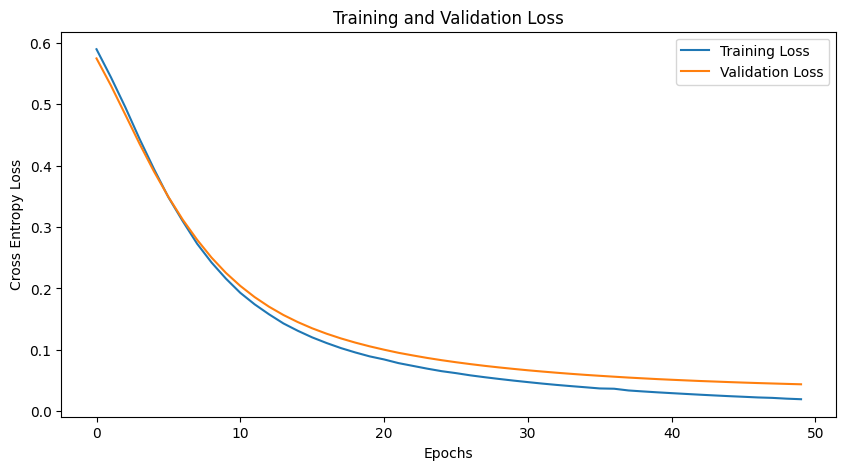

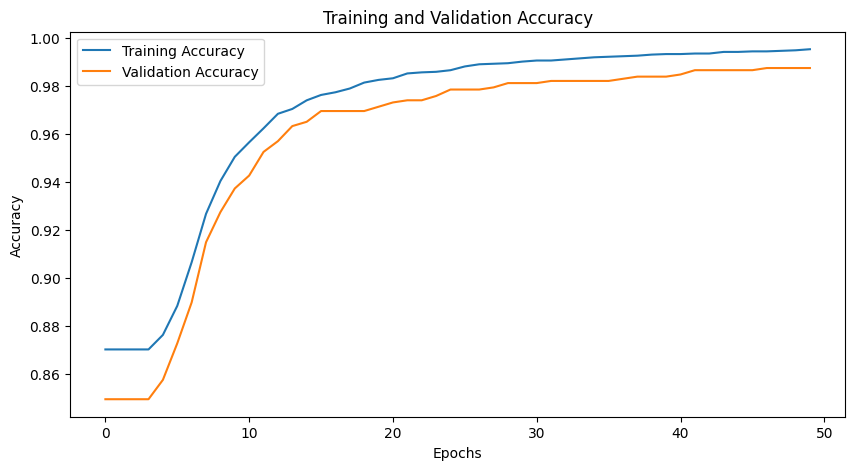

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


## 7. Error analysis

In [47]:
import torch
import torch.nn.functional as F
import pandas as pd

# Function to evaluate the model and get worst predictions
def evaluate_worst_predictions(model, dataloader, tokenizer, device=device):
    model.eval()  # Set model to evaluation mode
    
    all_predictions = []
    all_labels = []
    all_errors = []
    all_inputs = []

    with torch.no_grad():  # No gradients needed during evaluation
        for batch in dataloader:
            inputs, labels = batch  # Assuming (inputs, labels) in DataLoader
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            model.to(device)
            outputs = model(inputs)

            # Convert outputs to predicted class (for classification)
            if outputs.shape[-1] > 1:  # Multi-class classification
                preds = torch.argmax(outputs, dim=1)
                errors = (preds != labels).float()  # Misclassified observations
            else:  # Regression
                preds = outputs.squeeze()
                errors = torch.abs(preds - labels)  # Absolute error

            # Save results
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_errors.extend(errors.cpu().numpy())
            all_inputs.extend(inputs.cpu().numpy())

    # Convert to DataFrame for analysis
    df_results = pd.DataFrame({
        "True_Label": all_labels,
        "Predicted": all_predictions,
        "Error": all_errors,
        "Inputs": all_inputs,
        "Text" : [tokenizer.decode(input) for input in all_inputs]
    })

    # Sort by highest error (worst predictions)
    df_results_sorted = df_results.sort_values(by="Error", ascending=False)

    return df_results_sorted

# Example usage:
worst_predictions_val = evaluate_worst_predictions(model, val_loader, tokenizer, device='cpu')
worst_predictions_train = evaluate_worst_predictions(model, train_loader, tokenizer, device='cpu')


In [39]:
print("Train set prediction error")
worst_predictions_train.groupby("True_Label")["Error"].mean()

Train set prediction error


True_Label
0.0    0.009686
1.0    0.046588
Name: Error, dtype: float32

In [40]:
print("Train set distribution")
worst_predictions_train["True_Label"].value_counts()

Train set distribution


True_Label
0.0    3878
1.0     579
Name: count, dtype: int64

In [41]:
print("Validation set prediction error")
worst_predictions_val.groupby("True_Label")["Error"].mean()

Validation set prediction error


True_Label
0.0    0.014565
1.0    0.089514
Name: Error, dtype: float32

In [42]:
print("Validation set distribution")
worst_predictions_val["True_Label"].value_counts()

Validation set distribution


True_Label
0.0    947
1.0    168
Name: count, dtype: int64

## Matrice de confusion

In [48]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
from sklearn.metrics import classification_report

In [ ]:
true_labels = worst_predictions_train['True_Label']
predicted_labels = np.round(worst_predictions_train['Predicted'])
print(classification_report(true_labels, predicted_labels))

confusion = pd.DataFrame(confusion_matrix(true_labels, predicted_labels),
             index=["ham","spam"],
             columns=["ham","spam"])

px.imshow(confusion,
          text_auto=True,
          title="Matrice de Confusion sur le Train (Ham vs Spam)")

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3878
         1.0       1.00      0.97      0.98       579

    accuracy                           1.00      4457
   macro avg       1.00      0.98      0.99      4457
weighted avg       1.00      1.00      1.00      4457



In [ ]:
true_labels = worst_predictions_val['True_Label']
predicted_labels = np.round(worst_predictions_val['Predicted'])
print(classification_report(true_labels, predicted_labels))

confusion = pd.DataFrame(confusion_matrix(true_labels, predicted_labels),
             index=["ham","spam"],
             columns=["ham","spam"])

px.imshow(confusion,
          text_auto=True,
          title="Matrice de Confusion sur le Val (Ham vs Spam)")

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       947
         1.0       0.99      0.92      0.96       168

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



# IV - Transfert learning
Fine-tuning a model with the Trainer API

In [51]:
from datasets import Dataset
# Convertir le DataFrame Pandas en un objet Dataset de Hugging Face
full_dataset = Dataset.from_pandas(data)

# Diviser le dataset en entraînement et test (très recommandé)
train_test_split = full_dataset.train_test_split(test_size=0.2, seed=42)
df = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']})

NameError: name 'DatasetDict' is not defined

In [ ]:
# Load model distilbert-base-uncased
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length")

tokenized_datasets = df.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
tokenized_datasets

Map: 100%|██████████| 1115/1115 [00:00<00:00, 3981.84 examples/s]


DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4457
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1115
    })
})

In [ ]:
from transformers import TrainingArguments, AutoModelForSequenceClassification

training_args = TrainingArguments("test-trainer",report_to="none")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    processing_class=tokenizer,
)


In [ ]:
trainer.train()


Step,Training Loss
500,0.076600
1000,0.026000
1500,0.010400


TrainOutput(global_step=1674, training_loss=0.034053869750194934, metrics={'train_runtime': 1721.0309, 'train_samples_per_second': 7.769, 'train_steps_per_second': 0.973, 'total_flos': 1771221587429376.0, 'train_loss': 0.034053869750194934, 'epoch': 3.0})

### Predictions

In [ ]:
import numpy as np
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
from sklearn.metrics import classification_report
true_labels = tokenized_datasets["test"]["labels"]
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       970
           1       0.99      0.96      0.97       145

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [ ]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
confusion = pd.DataFrame(confusion_matrix(true_labels, preds),
             index=["ham","spam"],
             columns=["ham","spam"])
px.imshow(confusion,
          text_auto=True)

In [ ]:
true_labels = worst_predictions_val['True_Label']
predicted_labels = np.round(worst_predictions_val['Predicted'])

from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

from sklearn.metrics import confusion_matrix
import plotly.express as px
confusion = pd.DataFrame(confusion_matrix(true_labels, predicted_labels),
             columns=["pred_HAM","pred_SPAM"],
             index=["true_HAM","true_SPAM"])
px.imshow(confusion,
          text_auto=True)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       973
         1.0       0.99      0.94      0.97       142

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



# V - Comparaison & conclusions